In [1]:
import os
import yaml
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import cv2
import sys
import random
from tqdm import tqdm

os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')
sys.path.append('src')

from src.dataset import TrainingDataset

In [2]:
with open('config.yaml') as f:
    cfg = yaml.safe_load(f)
    
cfg

{'data_path': 'data',
 'images_dir': 'data/images',
 'masks_dir': 'data/masks',
 'split_path': 'data/split.json',
 'train_split': 250,
 'val_split': 100,
 'test_split': 50,
 'n_random_patches_per_image': 28,
 'patch_size': 256,
 'patch_overlap': 0.5,
 'train_batch_size': 32,
 'val_batch_size': 32,
 'num_workers': 12}

In [3]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [ ]:
dataset = TrainingDataset(
    image_filepaths = image_filepaths,
    mask_filepaths = mask_filepaths,
    n_random_patches_per_image = cfg['n_random_patches_per_image'],
    patch_size = cfg['patch_size']
)

## TRANSFORM PIPELINE

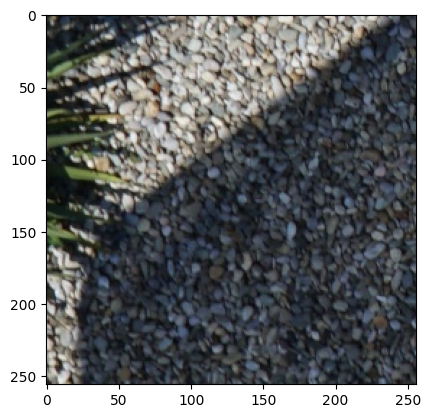

In [67]:
patch_image, patch_mask = dataset[5439]

plt.imshow(patch_image.permute(1, 2, 0))
plt.show()

0 3
tensor([0, 1, 2, 3], dtype=torch.uint8)


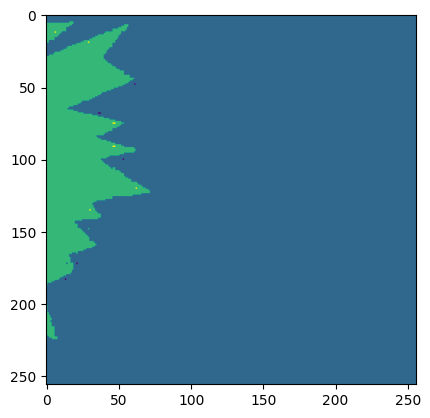

In [68]:
print(torch.min(patch_mask).item(), torch.max(patch_mask).item())
print(torch.unique(patch_mask))

plt.imshow(patch_mask)
plt.show()

In [70]:
patch_image.dtype, patch_mask.dtype

(torch.uint8, torch.uint8)

In [84]:
patch_image.shape, patch_mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [98]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5), # dual transform
    A.RandomBrightnessContrast(p=0.5), # image only transform
    A.HueSaturationValue(hue_shift_limit=100, sat_shift_limit=100, val_shift_limit=100, p=1), # image only transform
    A.RandomGamma(p=0.5), # image only transform
])

In [99]:
transformed = transforms(
    image = patch_image.numpy().transpose(1, 2, 0),  # to np.array [H, W, C]
    mask = patch_mask.numpy()
)

In [100]:
patch_image_transf = transformed['image']
patch_mask_transf = transformed['mask']

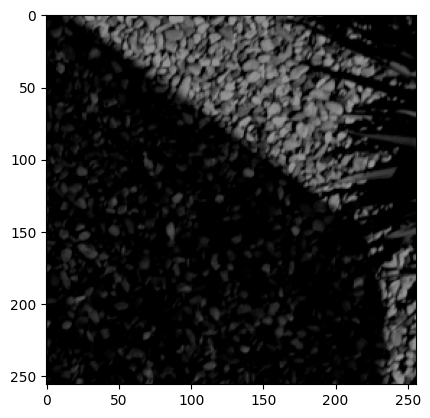

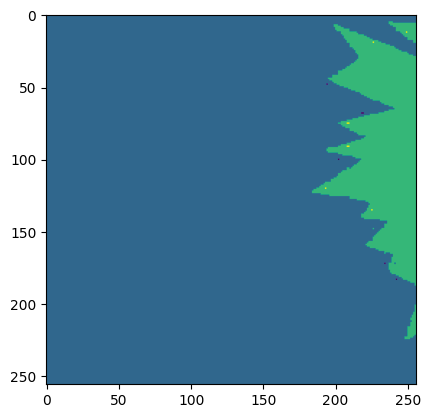

In [101]:
plt.imshow(patch_image_transf)
plt.show()

plt.imshow(patch_mask_transf)
plt.show()

In [104]:
# Check if mask pixels have been changed (they should not!)
patch_mask.sum().item(), patch_mask_transf.sum()

(72332, 72332)

- Apply Albumentation transforms to np.arrays.
- Image array must have shape [H, W, C], while mask array can have shape [H, W]. 

## TESTING SOME TRANSFORMS

In [ ]:
patch_image, patch_mask = dataset[5439]

plt.imshow(patch_image.permute(1, 2, 0))
plt.show()

plt.imshow(patch_mask)
plt.show()

In [ ]:
idx = random.randint(0, len(dataset))
print(idx)

patch_image, patch_mask = dataset[idx]

mytransform = A.CLAHE(p=1.0)

transformed = mytransform(image=patch_image.numpy().transpose(1, 2, 0), mask=patch_mask.numpy())
patch_image_transf = transformed['image']
patch_mask_transf = transformed['mask']
# print(patch_image_transf.sum())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].imshow(patch_image.numpy().transpose(1, 2, 0))
axs[0].set_title('original')
axs[0].axis('off')

axs[1].imshow(patch_image_transf)
axs[1].set_title('transformed')
axs[1].axis('off')

plt.show()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].imshow(patch_mask.numpy())
axs[0].set_title('original')
axs[0].axis('off')

axs[1].imshow(patch_mask_transf)
axs[1].set_title('transformed')
axs[1].axis('off')

plt.show()

In [43]:
torch.unique(patch_mask, return_counts=True)

(tensor([1, 2, 3], dtype=torch.uint8), tensor([14148, 45161,  6227]))

## TRAIN TRANSFORMS

Find adeguate set of transforms and their parameters for this dataset.

In [6]:
from albumentations.pytorch.transforms import ToTensorV2

In [7]:
train_transforms = A.Compose([
    # Dual transforms
    A.Affine(
        scale = (0.8, 1.2),
        rotate = (-360, 360),
        shear = (-20, 20),
        p = 0.5
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # Image only transforms
    A.ColorJitter(
        brightness = 0.5,
        contrast = 0.5,
        saturation = 0.5,
        hue = 0,
        p = 0.5
    ),
    A.CLAHE(p=0.5),
    A.Normalize(mean=(0.4456, 0.4436, 0.4018), std=(0.2220, 0.2154, 0.2298), p=1), # mean and std computed on this dataset,
    A.pytorch.ToTensorV2()
])

In [ ]:
idx = random.randint(0, len(dataset))
print(idx)

patch_image, patch_mask = dataset[idx]

transformed = train_transforms(image=patch_image.numpy().transpose(1, 2, 0), mask=patch_mask.numpy())
patch_image_transf = transformed['image']
patch_mask_transf = transformed['mask']
# print(patch_image_transf.sum())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Image
axs[0].imshow(patch_image.numpy().transpose(1, 2, 0))
axs[0].set_title('original')
axs[0].axis('off')
axs[1].imshow(patch_image_transf)
axs[1].set_title('transformed')
axs[1].axis('off')
plt.show()

# Mask
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].imshow(patch_mask.numpy())
axs[0].set_title('original')
axs[0].axis('off')
axs[1].imshow(patch_mask_transf)
axs[1].set_title('transformed')
axs[1].axis('off')
plt.show()

## TEST TRANSFORMS IN DATASET

In [4]:
from src.transforms import train_transforms

In [12]:
train_transforms

Compose([
  Affine(always_apply=False, p=0.5, interpolation=1, mask_interpolation=0, cval=0, mode=0, scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)}, rotate=(-360, 360), fit_output=False, shear={'x': (-20, 20), 'y': (-20, 20)}, cval_mask=0, keep_ratio=False, rotate_method='largest_box'),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  ColorJitter(always_apply=False, p=0.5, brightness=[0.5, 1.5], contrast=[0.5, 1.5], saturation=[0.5, 1.5], hue=[0, 0]),
  CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [6]:
dataset = TrainingDataset(
    image_filepaths = image_filepaths,
    mask_filepaths = mask_filepaths,
    n_random_patches_per_image = cfg['n_random_patches_per_image'],
    patch_size = cfg['patch_size'],
    transforms = train_transforms
)

In [9]:
[(type(x), x.shape) for x in dataset[0]]

[(torch.Tensor, torch.Size([3, 256, 256])),
 (torch.Tensor, torch.Size([256, 256]))]

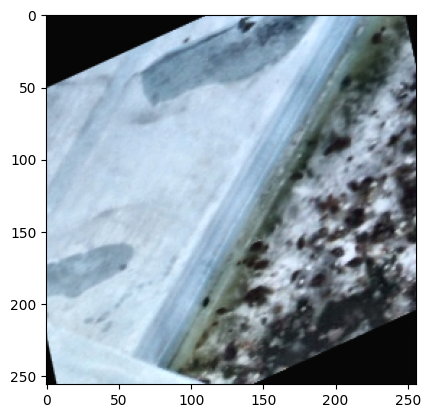

In [22]:
idx = random.randint(0, len(dataset))
plt.imshow(dataset[idx][0].numpy().transpose(1, 2, 0))